
#Building Responsible AI Solutions for Credit Risk and Financial Planning in Emerging Economies
# Responsible AI Masterclass
## Fair & Responsible Credit Scoring using XGBoost + Veritas Toolkit


##### **Date**: June 2025
___

## 🎯 Understanding Fairness in Financial AI

In the context of predictive underwriting or credit scoring, fairness means that individuals should be treated equitably — especially across protected attributes such as **gender**, **race**, or **age**.

Financial models must avoid unfair bias where:
- Certain groups (e.g., women or minorities) are denied opportunities more often than others.
- Errors (false positives or false negatives) disproportionately affect underrepresented groups.

Ensuring fairness in these models is not only **ethical**, but often required by regulatory bodies and critical for trust in financial services.


## 🔍 Why Use the Veritas Toolkit?

The Veritas Toolkit helps us go beyond basic model accuracy by diagnosing and explaining **bias and fairness trade-offs** in machine learning.

In this tutorial, we’re using the `PredictiveUnderwriting` use case to:
- Evaluate fairness across gender and race
- Identify if the model meets a fairness threshold (e.g. 80% rule)
- Generate explainable diagnostics for root cause analysis

This is a real-world simulation of **responsible AI in underwriting**, tailored for emerging economies.


## Initial Setup and Imports

In [ ]:
!python --version

Python 3.11.12


In [ ]:
# Ignore Python version in installation (since Colab's Python version is higher than requirements set by Veritas in its setup.py)
!pip install --ignore-requires-python veritastool

In [ ]:
# Import dependencies
import io
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import requests
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

from veritastool.model.model_container import ModelContainer
from veritastool.usecases.credit_scoring import CreditScoring
from veritastool.usecases.predictive_underwriting import PredictiveUnderwriting

pd.options.display.max_columns = 999

___
## Context and Dataset
- Credit risk assesses the probability that a borrower will fail to meet their loan obligations, representing a financial risk to the lender.
- Upon receiving a loan application, a bank must decide to approve or reject it based on the applicant's profile. This decision involves two primary risks:
  - Approving a loan for a high-risk applicant (unlikely to repay) leads to financial losses.
  - Rejecting a loan for a low-risk applicant (likely to repay) results in a missed business opportunity.
- Financial institutions face these risks when offering products like mortgages, credit cards, or personal loans due to the potential for borrowers to fail in fulfilling their repayment obligations.
- These financial institutions assess this risk by examining factors such as the borrower's credit history, repayment capacity, loan details, annual income, etc.
- To reduce potential losses, banks implement decision rules to determine loan approvals, taking into account an applicant's demographic and socio-economic characteristics.
- In this session, we shall explore the German Credit Data. It includes information on 20 variables for 1,000 applicants, classifying them as either a good or bad credit risk.
- A predictive model developed on this data can aid bank managers in making informed loan approval decisions based on the applicant profiles.



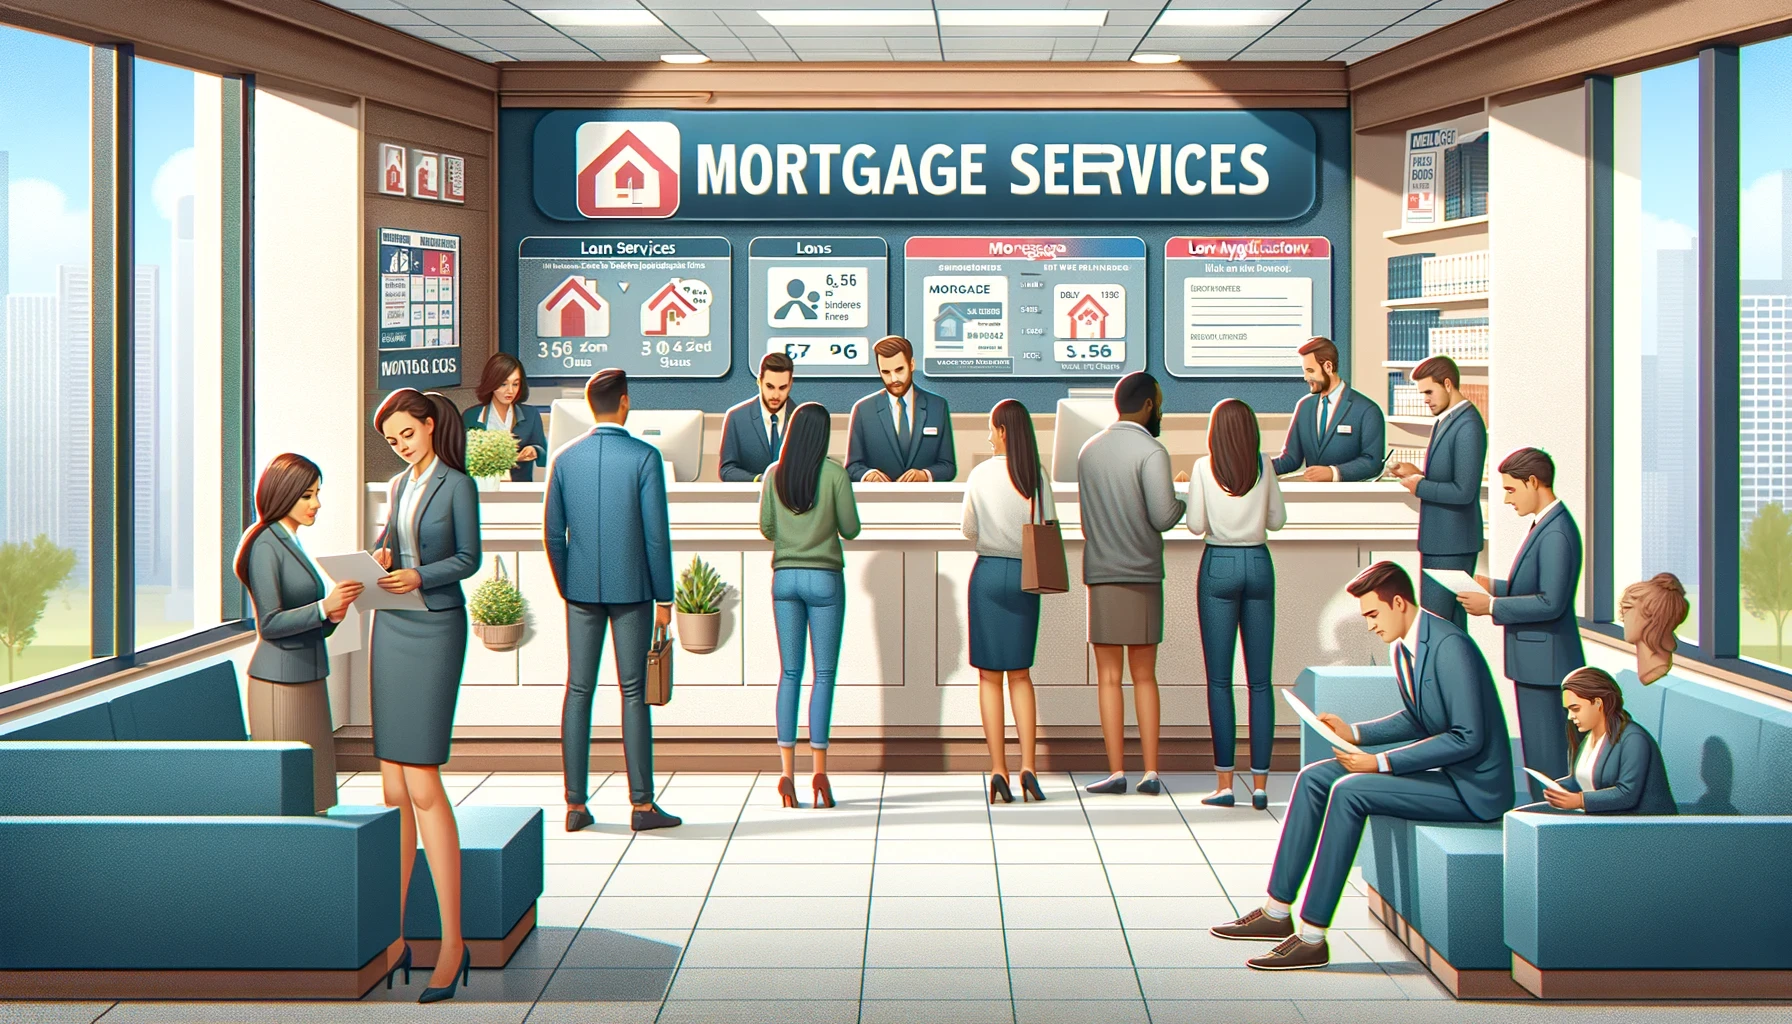

*Image generated by GPT-4*
___

In [ ]:
# Read credit rating dataset from STAT 897D - Applied Data Mining and Statistical Learning website
df = pd.read_csv('https://online.stat.psu.edu/stat857/sites/onlinecourses.science.psu.edu.stat857/files/german_credit/index.csv')
df.sample(5)

Creditability  Account Balance  Duration of Credit (month)  \
710              1                4                          24   
725              1                2                          18   
590              1                1                          12   
325              1                4                          24   
167              1                4                          24   

     Payment Status of Previous Credit  Purpose  Credit Amount  \
710                                  2        0           3757   
725                                  2        1           2779   
590                                  2        2           1657   
325                                  4        0           1287   
167                                  4        9           4526   

     Value Savings/Stocks  Length of current employment  Instalment per cent  \
710                     1                             5                    4   
725                     1                             3                    1   
590                     1                             3                    2   
325                     4                             5                    4   
167                     1                             3                    3   

     Sex & Marital Status  Guarantors  Duration in Current address  \
710                     2           2                            4   
725                     4           1                            3   
590                     3           1                            2   
325                     2           1                            4   
167                     3           1                            2   

     Most valuable available asset  Age (years)  Concurrent Credits  \
710                              4           62                   3   
725                              3           21                   3   
590                              1           27                   3   
325                              1           37                   3   
167                              1           74                   3   

     Type of apartment  No of Credits at this Bank  Occupation  \
710                  3                           1           3   
725                  1                           1           3   
590                  2                           1           3   
325                  2                           2           3   
167                  2                           1           4   

     No of dependents  Telephone  Foreign Worker  
710                 1          2               1  
725                 1          2               1  
590                 1          1               1  
325                 1          2               1  
167                 1          2               1

In [ ]:
df.columns

Index(['Creditability', 'Account Balance', 'Duration of Credit (month)',
       'Payment Status of Previous Credit', 'Purpose', 'Credit Amount',
       'Value Savings/Stocks', 'Length of current employment',
       'Instalment per cent', 'Sex & Marital Status', 'Guarantors',
       'Duration in Current address', 'Most valuable available asset',
       'Age (years)', 'Concurrent Credits', 'Type of apartment',
       'No of Credits at this Bank', 'Occupation', 'No of dependents',
       'Telephone', 'Foreign Worker'],
      dtype='object')

 The selected attributes are:

Age (numeric)

Sex (text: male, female)

Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)

Housing (text: own, rent, or free)

Saving accounts (text - little, moderate, quite rich, rich)

Checking account (numeric, in DM - Deutsch Mark)

Credit amount (numeric, in DM)

Duration (numeric, in month)

Purpose (text: car, furniture/equipment, radio/TV, domestic

appliances, repairs, education, business, vacation/others)


Source: UCI



In [ ]:
# Rename columns into better format (lower case with underscore separator)
df.columns = [
    'creditability', 'account_balance', 'duration_of_credit_months',
    'payment_status_of_previous_credit', 'purpose', 'credit_amount',
    'value_savings_stocks', 'length_of_current_employment', 'instalment_percent',
    'sex_marital_status', 'guarantors', 'duration_in_current_address',
    'most_valuable_available_asset', 'age', 'concurrent_credits',
    'type_of_apartment', 'no_of_credits_at_this_bank', 'occupation',
    'no_of_dependents', 'telephone', 'foreign_worker'
]

In [ ]:
# View null value count (we will see that we are dealing with a very clean dataset for demo purposes)
df.isnull().sum()

creditability                        0
account_balance                      0
duration_of_credit_months            0
payment_status_of_previous_credit    0
purpose                              0
credit_amount                        0
value_savings_stocks                 0
length_of_current_employment         0
instalment_percent                   0
sex_marital_status                   0
guarantors                           0
duration_in_current_address          0
most_valuable_available_asset        0
age                                  0
concurrent_credits                   0
type_of_apartment                    0
no_of_credits_at_this_bank           0
occupation                           0
no_of_dependents                     0
telephone                            0
foreign_worker                       0
dtype: int64

In [ ]:
# Label 1 = good risk (credit-worthy), 0 = bad risk
df['creditability'].value_counts()

1    700
0    300
Name: creditability, dtype: int64

___
## Train ML model (XGBoost) for Credit Scoring

In [ ]:
# Define feature matrix and target vector (dependent variable)
X = df.drop('creditability', axis=1)
y = df['creditability']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0)

In [ ]:
# Fit a basic XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                            n_estimators=100,
                            learning_rate=0.1,
                            max_depth=5,
                            seed=42)
model = xgb_clf.fit(X_train, y_train)

Training Accuracy: 0.9775
Test Accuracy: 0.775

F1 Score (Test): 0.8464163822525597

ROC AUC Score (Test): 0.8107174688057042

Confusion Matrix:
 [[ 31  37]
 [  8 124]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.46      0.58        68
           1       0.77      0.94      0.85       132

    accuracy                           0.78       200
   macro avg       0.78      0.70      0.71       200
weighted avg       0.78      0.78      0.76       200



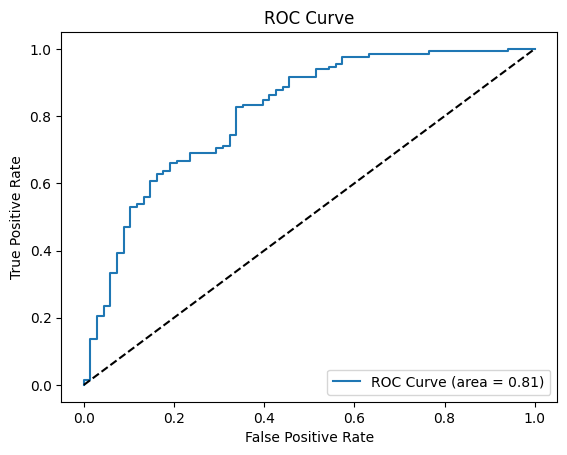

In [ ]:
# Predict on training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Generate prediction probabilities
y_test_proba = xgb_clf.predict_proba(X_test)[:, 1]

print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nF1 Score (Test):", f1_score(y_test, y_test_pred))
print("\nROC AUC Score (Test):", roc_auc_score(y_test, y_test_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc_score(y_test, y_test_proba))
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

___
## Fairness Diagnosis
**Use case: Evaluation of Fairness in credit scoring related applications**
- Let's explore how to evaluate fairness in our XGBoost model's predictions using specific fairness metrics.
- Before delving into the code, it's crucial to grasp the concepts of protected variables and privileged/unprivileged groups.
- **Protected variables** are attributes that divide a population into groups that should achieve parity in outcome parity (e.g., credit-worthiness) parity, such as race, gender, caste, and religion. These variables are context-dependent and vary by application.
- In this example, we shall set `foreign_worker` and `sex_marital_status` as the protected variables where we hypothesize that potential biases may exist.
- **Privileged** and **unprivileged** groups are typically determined by analyzing statistical representations (e.g., minority groups) or historical biases, supplemented by insights from subject matter experts (SMEs).
- Representation bias, for instance, occurs when data under-represents certain groups, making them likely unprivileged, while over-represented groups are deemed privileged.
- Alternatively, historical biases can define privileged groups. For example, groups with higher educational backgrounds might historically enjoy privileges in credit scoring systems that pre-date the adoption of AI and ML models.
- It is essential to confirm these identified groups with domain-specific knowledge.
- Some sample examples of protected groups include:
  - Gender: Female vs. Male
  - Marital Status: Single vs. Others
  - Race: Chinese vs. Others

### (1) Define protected variables and privileged groups
- We shall use statistical representation to define the privileged and unprivileged groups

In [ ]:
# Understanding value distribution in protected groups (Foreign Worker)
df['foreign_worker'].value_counts()

1    963
2     37
Name: foreign_worker, dtype: int64

In [ ]:
# Understanding value distribution in protected groups (Sex and Marital Status)
df['sex_marital_status'].value_counts()

3    548
2    310
4     92
1     50
Name: sex_marital_status, dtype: int64

In [ ]:
# Define privileged/unprivileged groups (assuming minority groups based on proportion are unprivileged)
p_grp = {'foreign_worker':[1], 'sex_marital_status':[2, 3]} # Privileged 2 has engaged and 3 as married
up_grp = {'foreign_worker':[2], 'sex_marital_status':[1, 4]} # unprivileged 1 as single and 4 as divorce

In [ ]:
len(y_test_pred)

200

### (2) Create model container
- We then take the generic machine learning inputs and create a ModelContainer class object. This helper class holds the model parameters required for computations in all use cases (e.g., credit scoring, predictive underwriting, etc)
- The explanations for the class parameters are found in the comments below.
- Note that the `pos_label` is set as 1 because the class label 1 is considered favorable since it indicates the customer is credible and thus credit-worthy, making them suitable for loan issuance.

In [ ]:
container = ModelContainer(y_true=y_test, # Ground truth target values
                           pos_label=[1], # Label values which are considered favorable
                           model_type="classification", # Default is classification. Others include "uplift" and "regression"
                           model_name='credit_scoring', # Name of model artifact json file
                           y_pred=y_test_pred, # Predicted targets
                           y_prob=y_test_proba, # Predicted probabilities
                           y_train=y_train, # Ground truth for training data
                           x_train=X_train, # Training dataset
                           x_test=X_test, # Test dataset
                           model_object=model, # Model object used in feature importance section for training and prediction
                           p_grp=p_grp, # List of privileged groups within protected variables
                           up_grp=up_grp # List of underprivileged groups within protected variables
                           )

### (3) Create Use Case Object
- Veritas provides a suite of predefined classes tailored for frequent applications in financial services, including credit scoring and predictive underwriting.
- In this example, we'll utilize the credit scoring class from Veritas to assess and analyze fairness and transparency in our credit scoring model.
- The following are the source codes for the principles of fairness and transparency:
  - Fairness: https://github.com/mas-veritas2/veritastool/blob/main/veritastool/principles/fairness.py
  - Transparency: https://github.com/mas-veritas2/veritastool/blob/main/veritastool/principles/transparency.py

In [ ]:
credit_scoring_fairness = CreditScoring(model_params = [container], # Data holder that contains all model attributes to be assessed (container object created earlier)
                                        perf_metric_name="accuracy", # name of primary performance metric to be used
                                        fair_threshold = 80, # fairness threshold value (percent)
                                        fair_concern = "eligible", # single fairness concern applied to all protected variables: "eligible" (default), "inclusive", or "both"
                                        fair_priority = "benefit", # fairness metric according to Fairness Tree methodology: "benefit" (default) or "harm"
                                        fair_impact = "normal", # fairness metric according to Fairness Tree methodology: "normal" (default), "significant" or "selective"
                                        )

> **Note**: While we are currently using the specially designed use case objects, it's also possible to switch to the more generic BaseClassifier object provided by Veritas. This option is ideal for scenarios that don't fit into any of the predefined categories Veritas typically handles. More information can be found here: https://github.com/mas-veritas2/veritastool/blob/main/veritastool/examples/BaseClassification_demo.ipynb

___
### Deep Dive Explanations

#### (i) Details on CreditScoring class parameters
- "Benefit" was chosen as the fairness priority because issuing a loan based on a customer's creditworthiness typically poses no punitive or harmful effects.
- The "Eligible" group has been identified for focus because loan issuance is limited to customers who meet specific threshold and eligibility criteria.
- Regarding customer impact, it is set as "Normal" since it has been determined that there are no significant consequences associated with this model's outcomes, nor is there any selective process applied to those predicted as positive.
- The Fairness threshold is set at 80% (default value). Originating from employment law, it is suggested that if the positive outcome rate for a protected group is less than 80% of that for the most favored group, there might be potential bias.

#### (ii) General Definitions
- **Fairness Impact**: Describes the extent to which fairness measures affect a model's decisions. It assesses the changes in operational outcomes due to these measures:
  - **Normal**: Regular fairness measures are applied, assuming a typical impact on the model's decision-making process.
  - **Significant**: A higher sensitivity and stringent fairness requirement, often in scenarios with major consequences (like healthcare), where stricter metrics ensure equitable outcomes.
  - **Selective**: Customized fairness measures targeting specific, historically disadvantaged groups, aimed at addressing and correcting these disparities.
- **Fairness Concern**: Relates to ensuring decisions within a model are equitable, typically focusing on:
  - **Inclusive**: Ensures all groups are treated equitably, with metrics to maintain similar rates of errors across groups, relevant in decisions like loan approvals or job recommendations. Metrics like FPR parity (False Positive Rate parity) and FDR parity (False Discovery Rate parity) measure this by ensuring that the proportion of false positives or false discoveries is similar across groups. This could relate to receiving loans, being recommended for jobs, etc.  
  - **Eligible**: Targets equitable distribution of benefits among those meeting the model's criteria, with metrics to ensure true positives and minimize omissions fairly across groups, ensuring eligible individuals are not biasedly excluded from opportunities. Metrics like Equal Opportunity and FOR parity (False Omission Rate parity) are used here, where the concern is that the true positive rates or omission errors are equal across different groups. For example, eligible individuals should not be excluded from loan approvals or job offers due to biases in the model.
  - **Both**: Aims for multi-dimensional fairness, requiring parity in errors and calibrated probabilities across groups, ensuring inclusiveness while benefiting the eligible. Metrics like Equal Odds or Calibration by Group are used, which require parity in both false positive and false negative rates or calibrated probabilities across groups i.e.,  being inclusive while ensuring that only eligible individuals are positively impacted.

#### (iii) Fairness Decision Table
- Assumption: Positive label 1 of y-variable refers to a "favourable" outcome (which in this case is true, since creditability = 1 means that we deem the customer credible for a loan)  
- Each fairness metric like `fpr_parity`, `equal_odds`, `ppv_parity`, etc., addresses different statistical aspects of fairness, focusing on reducing bias in terms of false positive rates, false negative rates, or predictive values across different groups
- The following table shows the fairness metric that will automatically be chosen based on the settings we define for priority, impact, and concern:
___

| Priority | Impact | Concern | Fairness Metric |
|---------------|-------------|--------------|----------------------------|
| Benefit       | Normal      | Inclusive    | fpr_parity                 |
| Benefit       | Normal      | Eligible     | equal_opportunity          |
| Benefit       | Normal      | Both         | equal_odds                 |
| Benefit       | Significant or Selective| Inclusive    | fdr_parity                 |
| Benefit       | Significant or Selective | Eligible     | ppv_parity                 |
| Benefit       | Significant or Selective | Both         | *conflict_error*           |
| Harm          | Normal      | Inclusive    | fpr_parity                 |
| Harm          | Normal      | Eligible     | fnr_parity                 |
| Harm          | Normal      | Both         | equal_odds                 |
| Harm          | Significant or Selective | Inclusive    | fdr_parity                 |
| Harm          | Significant or Selective | Eligible     | for_parity                 |
| Harm          | Significant or Selective | Both         | calibration_by_group       |


#### (iv) Fairness Metrics
- The main aim of these fairness metrics is to evaluate whether equitable treatment is applied across different groups (like different races or genders) in our predictive models

- `fpr_parity`: False Positive Rate (FPR) Parity focuses on keeping the rate of incorrect positive predictions (where the model wrongly predicts a positive outcome) similar across all groups. This helps prevent bias against any one group, aiming for a more fair use of technology like in hiring or policing. Achieving FPR parity means that no particular group is unfairly subjected to the negative consequences of false alarms.  

- `equal_opportunity`: Equal Opportunity specifically focuses on the True Positive Rate, also known as recall or sensitivity. It ensures all groups have the same probability of receiving a positive prediction when the actual outcome is positive. In simpler terms, it measures whether the model is equally good at identifying true positives for all groups. For example, in a job application screening tool, Equal Opportunity would require that all qualified candidates have an equal chance of being shortlisted, regardless of their demographic group. It is focused only on the positive class and ensuring fairness among actual positives. This is crucial for ensuring that all qualified individuals have equal access to opportunities.

- `equal_odds`: Equal Odds extends the concept of Equal Opportunity by considering both True Positive Rate (TPR) and False Positive Rate (FPR). This means the model should be equally accurate and make mistakes at the same rate for every group. It not only measures whether the model is equally good at identifying true positives for all groups but also checks that all groups are equally likely to avoid false positive errors. For instance, a predictive policing tool meeting Equal Odds would neither overlook nor wrongly target any specific group disproportionately.


- `fnr_parity`: False Negative Rate (FNR) Parity focuses on keeping the rate of incorrect negative predictions (where the model wrongly predicts a negative outcome, aka incorrect negative predictions) similar across all groups. This helps prevent bias by ensuring that no group is unfairly missed for positive opportunities or interventions, aiming for a fair and equitable use of technology in areas like medical diagnoses or loan approvals  

- `fdr_parity`: False Discovery Rate (FDR) Parity focuses on keeping the rate of incorrect positive identifications (where the model wrongly predicts a positive outcome when it's false) similar across all groups. This helps to prevent biases by ensuring that no group is disproportionately represented in the errors of positive predictions. Achieving FDR parity means that the proportion of incorrect positive predictions relative to all positive predictions is balanced across different groups, promoting fairness in decisions like job promotions or school admissions.  

- `ppv_parity`: Positive Predictive Value (PPV) Parity, also known as precision parity focuses on keeping the proportion of correct positive predictions (where the model correctly predicts a positive outcome) similar across all groups. This metric helps to ensure that when a model predicts a positive outcome, it is just as likely to be correct, regardless of the group to which the individual belongs. Achieving PPV parity means that the accuracy of positive predictions is evenly distributed.

- `for_parity`: False Omission Rate (FOR) Parity focuses on keeping the rate of incorrect negative predictions (where the model wrongly predicts a negative outcome when it is false, aka incorrect omission of positives) similar across all groups. This metric helps to ensure that when a model predicts a negative outcome, it is just as likely to be incorrect, regardless of the group to which the individual belongs. Achieving FOR parity means that the likelihood of overlooking a true positive case is evenly distributed across groups, which is crucial in settings where failing to detect true positives can have significant consequences, such as in disease screening or safety inspections.

- `calibration_by_group`: Ensure that the predicted probabilities of an event are equally accurate across different demographic groups. It assesses whether the probability a model assigns to an outcome (like defaulting on a loan) matches the actual observed outcome rate for each group. For example, if a model predicts that two different groups each have a 30% probability of an event occurring, then in reality, approximately 30% of each group should experience the event if the model is well-calibrated.

___
#### (v) Examples
- Let us look at an example covering a few of the contextualized scenarios based on the fairness tree:

**Scenario 1**

| Priority | Impact | Concern | Fairness Metric |
|---------------|-------------|--------------|----------------------------|
| Benefit       | Normal      | Inclusive    | fpr_parity |


- Ensures that the rate at which individuals who would default are mistakenly approved for credit is similar across different demographic groups. If 5% of men who would default on their loan are mistakenly approved, the model should aim to have a similar rate for women to maintain `fpr_parity`.
  
___

**Scenario 2**

| Priority | Impact | Concern | Fairness Metric |
|---------------|-------------|--------------|----------------------------|
| Benefit       | Normal      | Eligible    | equal_opportunity |

- Ensures that all individuals who are creditworthy (those who would not default on their loan) have equal chances of being predicted as such, regardless of their demographic group (i.e., True Positive Rate). If 90% of creditworthy men are correctly predicted as being capable of repaying their loans, it should similarly predict 90% of creditworthy women, ensuring gender does not skew the prediction of creditworthiness.

___

**Scenario 3**

| Priority | Impact | Concern | Fairness Metric |
|---------------|-------------|--------------|----------------------------|
| Benefit       | Normal      | Both    | equal_odds |

- Combines requirements of equal false positive rates (FPR) and equal true positive rates (TPR), ensuring fairness in both approving and denying credit across all groups. If model maintains that 20% of non-creditworthy individuals are mistakenly approved (false positive rate) and 80% of creditworthy individuals are correctly approved (true positive rate) across all demographic groups, it achieves `equal_odds`.

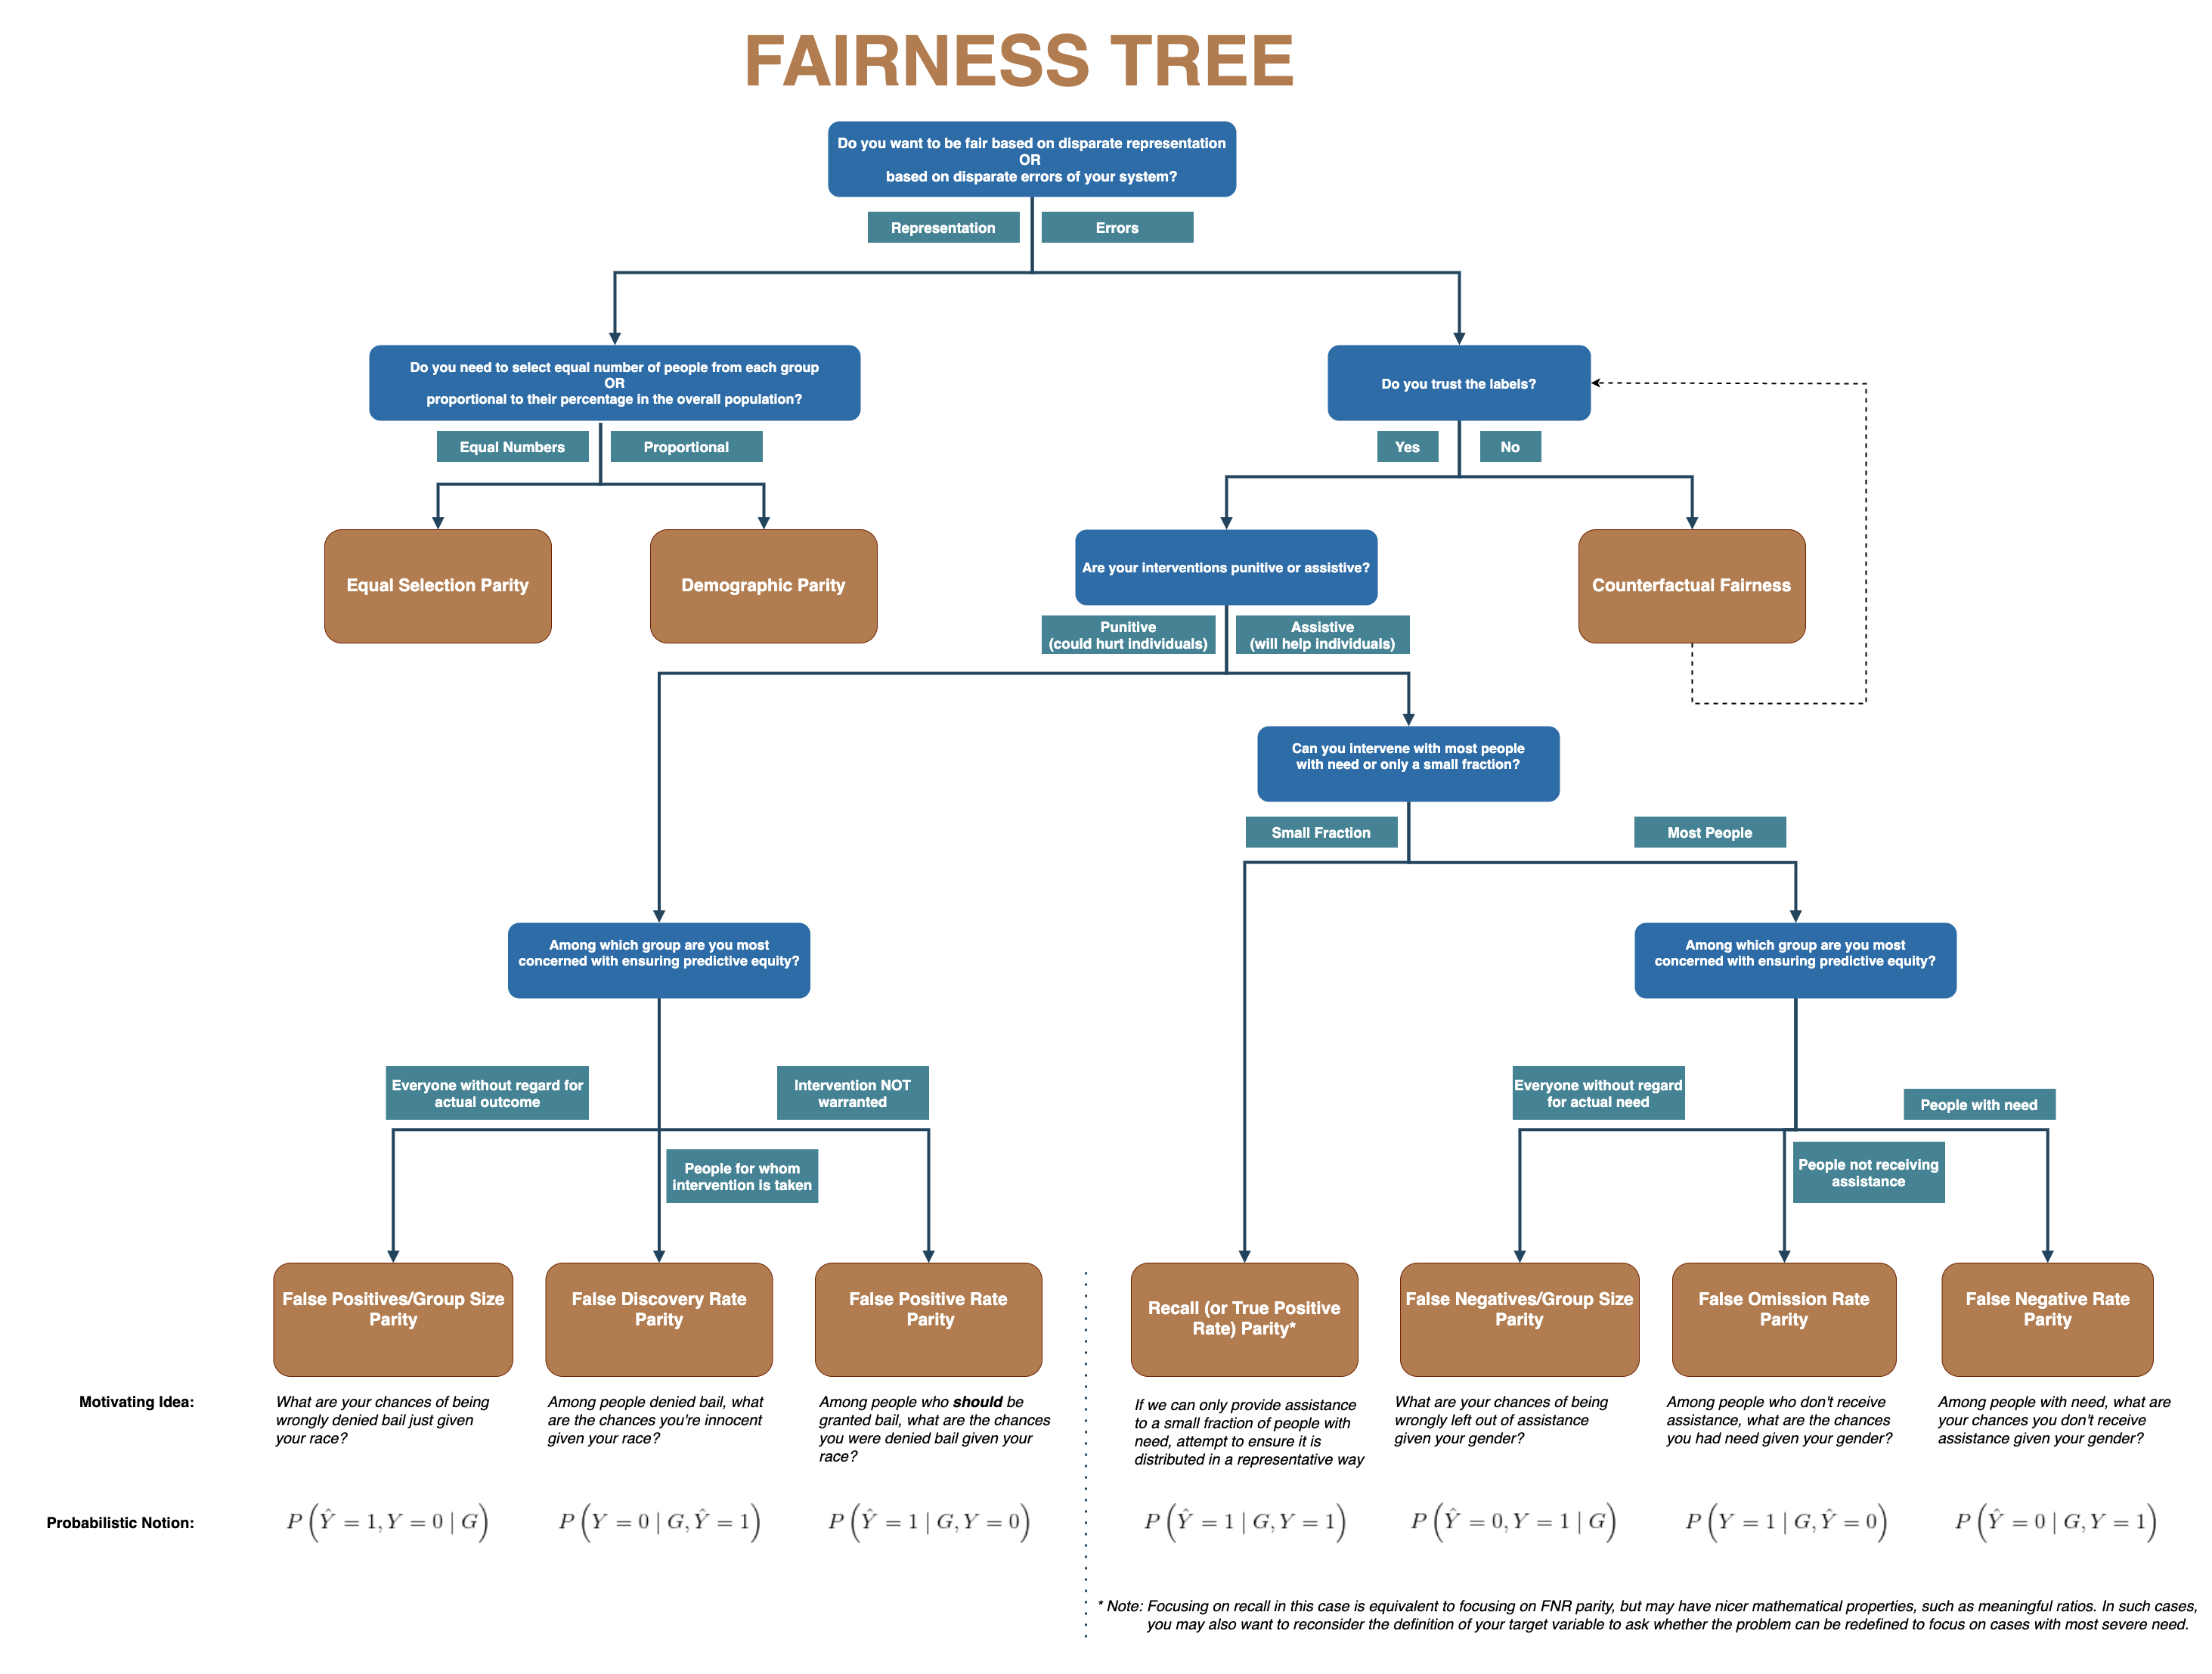

___
### (4) Run evaluation

The `evaluate()` method computes all performance and fairness metrics and renders it in a table format (default). It also highlights the primary performance and fairness metrics (automatic if not specified by user).

## 🧪 What Happens When We Call `.evaluate()`?

The `.evaluate()` function in the Veritas Toolkit performs the following:

1. **Computes performance metrics** (like accuracy) across all subgroups
2. **Calculates fairness metrics**:
   - Benefit Difference & Ratio
   - Selection Rate
   - True/False Positive Rate Disparities
3. **Compares metrics** for privileged vs. underprivileged groups
4. **Flags violations** if fairness falls below the threshold (e.g. 80%)

This gives a detailed picture of whether the model is fair — not just good at prediction.


In [ ]:
credit_scoring_fairness.evaluate()


Evaluate performance:   0%|          


Class Distribution
	pos_label                                                          66.000%
	neg_label                                                          34.000%


Performance Metrics
	Selection Rate                                             0.805 +/- 0.059
	Accuracy                                                   0.775 +/- 0.062
	Balanced Accuracy                                          0.698 +/- 0.067
	Recall                                                     0.939 +/- 0.039
	Precision                                                  0.770 +/- 0.073
	F1 Score                                                   0.846 +/- 0.047
	True Negative Rate                                         0.456 +/- 0.132
	False Negative Rate                                        0.061 +/- 0.039
	Negative Predictive Value                                  0.795 +/- 0.120
	ROC AUC Score                                              0.811 +/- 0.073
	Log-loss                                     

From the above, we see that the fairness criteria (80% threshold) is met. It means that our model is fair on the premise of equal opportunity.

In [ ]:
# Evaluate with visualization (It is only available on Jupyter notebook, not on Colab)
# Feel free to run this locally to view the viz
credit_scoring_fairness.evaluate(visualize = True)

The widget is only available on Jupyter notebook


#### Sample output from Jupyter Notebook
- Taken from Veritas Github repo
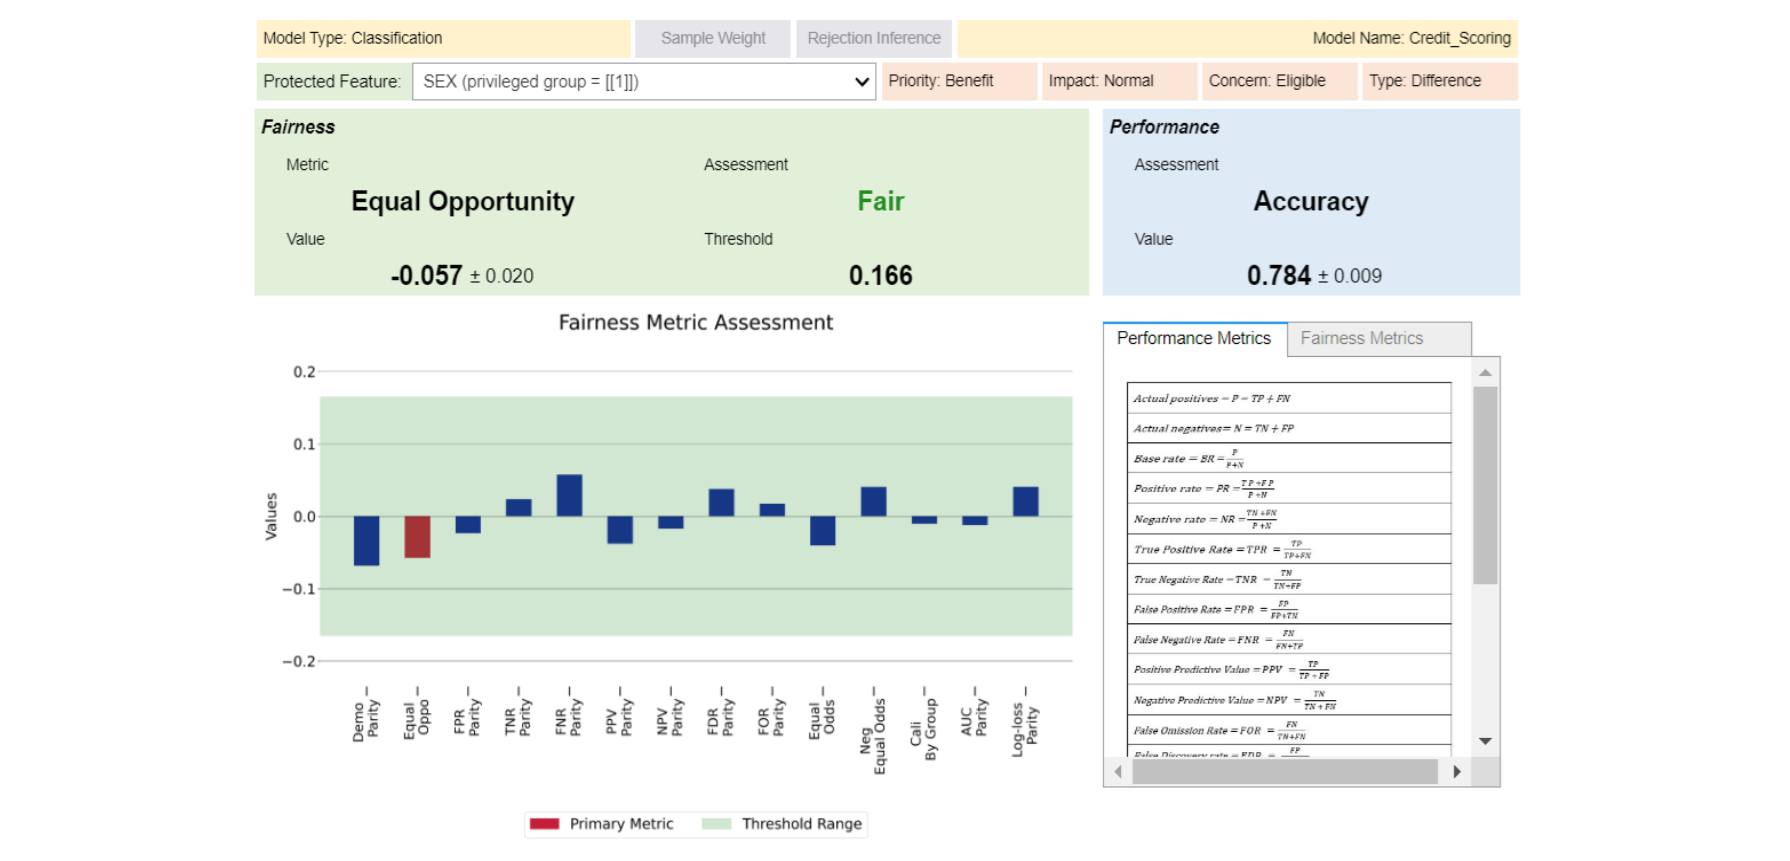

___
#### Tradeoff
- When assessing predictive models, it's crucial to calculate the trade-offs between performance and fairness metrics over various threshold values or probability cut-offs.
- This involves adjusting the threshold at which a prediction is considered positive, and observing how these adjustments impact both the model's accuracy and its fairness across different groups.
- Evaluating the "cost" of each unit of performance loss for a corresponding unit gain in fairness can be complex and sensitive.
- This conversation involves weighing the benefits of higher accuracy against the ethical implications of increased bias, which may affect the perceived fairness of the model.
- Such discussions need to be handled with care, as they can have significant consequences on decision-making processes, especially in high-stakes domains like healthcare or criminal justice.
- This balancing act is a pivotal part of developing responsible AI systems.
- We can generate the tradeoffs and thresholds using the `tradeoff()` method

In [ ]:
# Evaluate tradeoffs
credit_scoring_fairness.tradeoff()

Tradeoff:   0%|          


-------------------------- 1. foreign_worker  --------------------------
Performance versus Fairness Trade-Off
	 Single Threshold
		Privileged/Unprivileged Threshold                 0.304
		Best balanced_acc*                                0.740
	 Separated Thresholds
		Privileged Threshold                              0.696
		Unprivileged Threshold                            0.628
		Best balanced_acc*                                0.747
	 Separated Thresholds under Neutral Fairness (0.001)
		Privileged Threshold                              0.571
		Unprivileged Threshold                            0.667
		Best balanced_acc*                                0.736
		*estimated by approximation, subject to the resolution of mesh grid

------------------------ 2. sex_marital_status  ------------------------
Performance versus Fairness Trade-Off
	 Single Threshold
		Privileged/Unprivileged Threshold                 0.304
		Best balanced_acc*                                0.740
	 Separated

- The decision threshold is the probability cutoff that determines how predictions are classified into binary outcomes (1 or 0).
- Here's a breakdown of different strategies for setting thresholds:
  - Single Threshold: This approach uses a single optimal threshold across all groups to maximize a specific performance metric.
  - Separated Thresholds: Different optimal thresholds are set for each group, potentially improving outcomes for specific demographics but varying the performance metrics.
  - Separated Thresholds under Neutral Fairness: This strategy applies fairness constraints to the threshold settings, aiming to achieve equitable outcomes across groups. While this may enhance fairness, it could slightly reduce overall accuracy.
- These methods illustrate the delicate balance between fairness and accuracy in predictive modeling, particularly when tailored thresholds are used to address disparities among predefined privileged (P) and underprivileged (UP) groups.
- Applying a fairness constraint (neutral fairness) modifies the thresholds to ensure outcomes are more equitable, but this can sometimes lead to a small decrease in overall accuracy (See `foreign_worker`). This shows the practical challenge of balancing fairness and accuracy in machine learning models
  -  It refers to the fairness metrics controlled such that they do not deviate more than 0.001 from a predefined fair value.
___

#### Feature Importance
- Computes feature importance of protected features using leave one out analysis.
- The "leave-one-out analysis" is used to compute the importance of protected features. This technique involves systematically removing one feature at a time from the model to observe how its absence affects the model's performance.
- By doing this for protected attributes—such as race, gender, or age—the analysis helps identify how crucial each of these features is to the model's predictions.
- This can be particularly useful in understanding the impact of these features on the fairness and bias of the model, as removing a protected feature and observing a significant change in model performance could indicate that the model is heavily reliant on potentially biased or sensitive attributes.

In [ ]:
credit_scoring_fairness.feature_importance()

Feature importance:   0%|          




--------------------------------------------------1: Fairness on Foreign_Worker---------------------------------------------

----------------------------------------------------------------------------------------------------------------------------
|Removed Protected Variable    |accuracy                 |equal_opportunity        |Fairness Conclusion |Suggestion        |
----------------------------------------------------------------------------------------------------------------------------
|foreign_worker                |0.010                    |0.008                    |fair to fair (+)    |Exclude           |
----------------------------------------------------------------------------------------------------------------------------
|sex_marital_status            |-0.010                   |0.000                    |fair to fair        |Include           |
-------------------------------------------------------------------------------------------------------------------------

Correlation analysis :   0%|          

Permutation explainer: 801it [03:08,  4.11it/s]



Partial correlation matrix (Most correlated features for foreign_worker, sex_marital_status):


foreign_worker   purpose  credit_amount       age  \
foreign_worker            1.000000  0.193188       0.011694  0.209159   
purpose                   0.193188  1.000000       0.418499  0.000000   
credit_amount             0.011694  0.418499       1.000000  0.441900   
age                       0.209159  0.000000       0.441900  1.000000   
no_of_dependents          0.000000  0.172263       0.163407  0.290475   
sex_marital_status        0.182712  0.246962       0.333986  0.275668   

                    no_of_dependents  sex_marital_status  
foreign_worker              0.000000            0.182712  
purpose                     0.172263            0.246962  
credit_amount               0.163407            0.333986  
age                         0.290475            0.275668  
no_of_dependents            1.000000            0.390756  
sex_marital_status          0.390756            1.000000

* No surrogate detected based on correlation analysis (threshold=0.7).


___
#### Root Cause
- Computes the importance of variables contributing to the bias
- In the context of credit scoring fairness, analyzing the importance of variables contributing to bias involves identifying and quantifying how specific attributes influence the overall fairness of the model.
- The use of SHAP here provides a deep insight into the model by quantifying the impact of each variable on the outcome relative to a baseline. In doign so to analyze demographic parity, we can pinpoint which features disproportionately influence the likelihood of being classified as '1' (e.g., creditworthy), thus identifying areas where the model might be unfairly biased.

Root cause analysis:   0%|          



                         Top 10 contributors towards bias for class '1'
                           Measured by SHAP-based Demographic Parity   




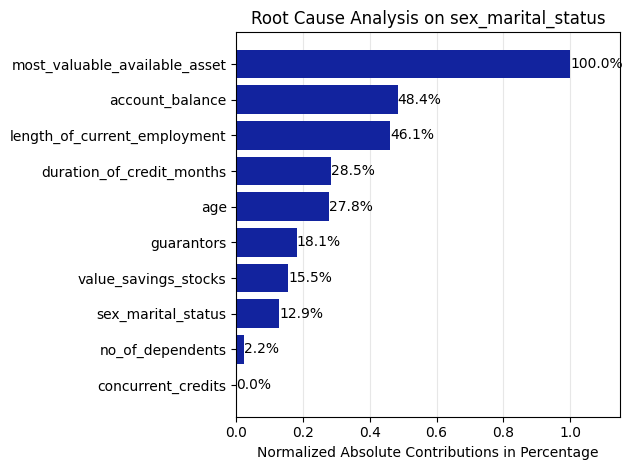

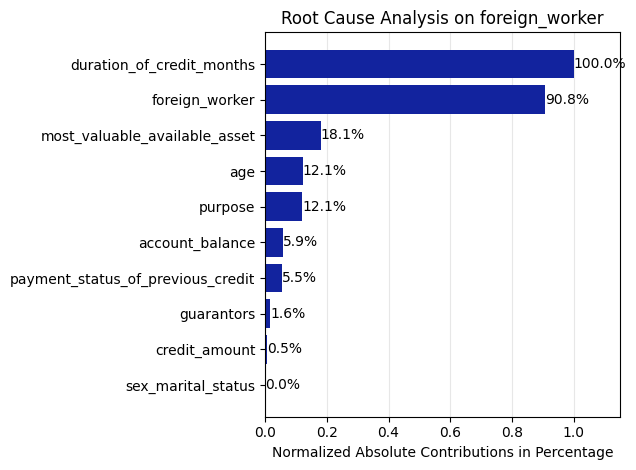

In [ ]:
credit_scoring_fairness.rootcause()

- In this context, the analysis is focused on the impact of the variable `sex_marital_status` and `foreign_worker` on model predictions.
- For `sex_marital_status`, the `most valuable available asset` is overwhelmingly the most influential feature affecting the prediction of class '1' (credit-worthy) under the consideration of bias by sex and marital status.
- It might be indicative of economic status, which could be unevenly distributed across different `sex_marital_status` groups.
- If this feature strongly influences the prediction toward a positive outcome (loan approval), it may suggest that the model is biased in favor of individuals with higher asset values, potentially disadvantaging those from less affluent backgrounds or those whose assets are undervalued due to systemic biases.

___
## Transparency Diagnosis
- Transparency diagnosis in machine learning assesses how clear and understandable a model's decisions are to users.
- It ensures that stakeholders can easily grasp why decisions are made, enhancing trust and accountability in areas where decision clarity is crucial, such as healthcare and finance.

In [ ]:
df.head()

creditability  account_balance  duration_of_credit_months  \
0              1                1                         18   
1              1                1                          9   
2              1                2                         12   
3              1                1                         12   
4              1                1                         12   

   payment_status_of_previous_credit  purpose  credit_amount  \
0                                  4        2           1049   
1                                  4        0           2799   
2                                  2        9            841   
3                                  4        0           2122   
4                                  4        0           2171   

   value_savings_stocks  length_of_current_employment  instalment_percent  \
0                     1                             2                   4   
1                     1                             3                   2   
2                     2                             4                   2   
3                     1                             3                   3   
4                     1                             3                   4   

   sex_marital_status  guarantors  duration_in_current_address  \
0                   2           1                            4   
1                   3           1                            2   
2                   2           1                            4   
3                   3           1                            2   
4                   3           1                            4   

   most_valuable_available_asset  age  concurrent_credits  type_of_apartment  \
0                              2   21                   3                  1   
1                              1   36                   3                  1   
2                              1   23                   3                  1   
3                              1   39                   3                  1   
4                              2   38                   1                  2   

   no_of_credits_at_this_bank  occupation  no_of_dependents  telephone  \
0                           1           3                 1          1   
1                           2           3                 2          1   
2                           1           2                 1          1   
3                           2           2                 2          1   
4                           2           2                 1          1   

   foreign_worker  
0               1  
1               1  
2               1  
3               2  
4               2

We include transparency diagnosis by expanding on the `CreditScoring` class we built earlier

In [ ]:
credit_scoring_transparency = CreditScoring(model_params = [container],
                                            perf_metric_name="accuracy",
                                             fair_threshold = 80,
                                             fair_concern = "eligible",
                                             fair_priority = "benefit",
                                             fair_impact = "normal",
                                            # Transparency parameters
                                            tran_row_num = [20,40], # Holds the list of indices for which user wants to see local interpretability
                                            # tran_pdp_feature = ['credit_amount', 'no_of_dependents', 'duration_in_current_address'], # Stores features for visualization of partial dependence plots
                                            tran_max_display = 10  # Stores number of features to see in output
                                            )

`.explain()` runs the transparency analysis - global & local interpretability, partial dependence analysis and permutation importance

Running transparency for model 1        done      


Permutation explainer: 801it [01:46,  6.84it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


     Data preparation                   done      
     Interpretability                   done      
     Partial dependence                 done      


Computing Permutation Importance:   0%|          

     Permutation importance             done      


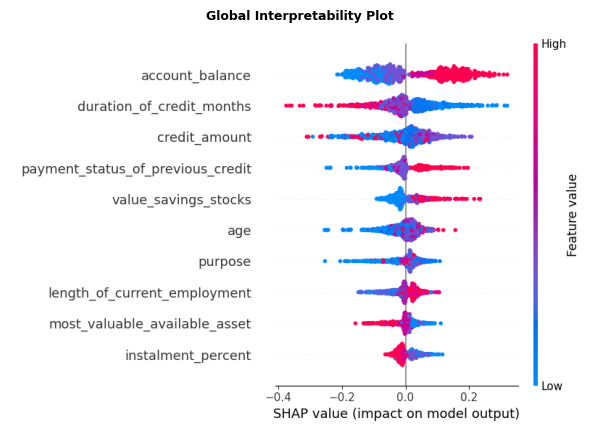

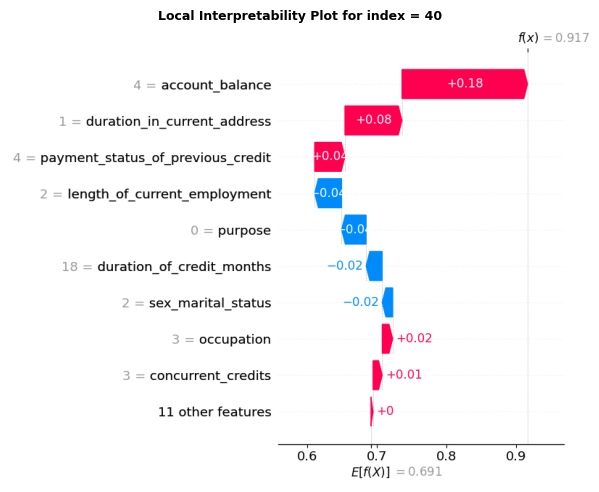

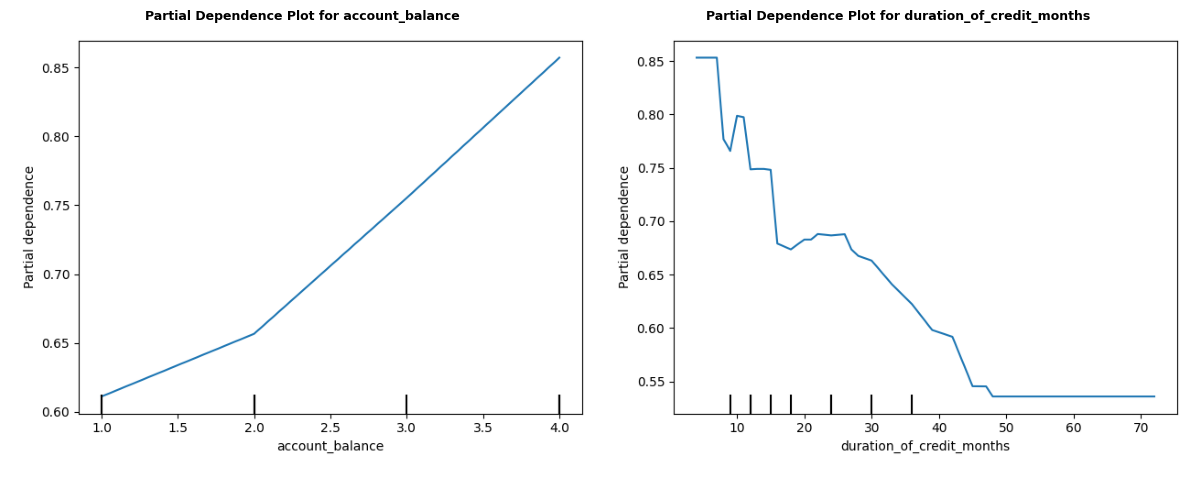

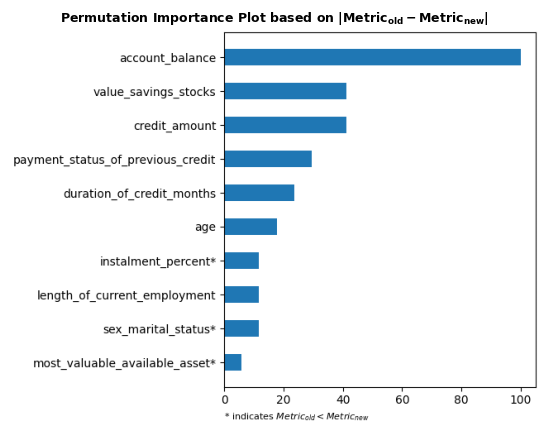

In [ ]:
credit_scoring_transparency.explain()

**More on Partial Dependence Plots**
- Partial Dependence Plots (PDPs) are calculated by systematically varying the feature of interest across its range of values while keeping other features fixed at their average or distribution values to observe how these variations affect the predicted outcome from a model.
- For this case, the y-axis of the PDP plot above represents the partial dependence of the likelihood of loan approval on the duration of the credit (duration_of_credit_months)
- For example, in the `account_balance` PDP, there is a clear trend to show that the greater the account balance of the customer, the greater the likelihood of being considered "creditable"

___
## Hands-on Practical
- We are now ready to explore (and get hands-on practice on) a new use case and dataset with Veritas, focusing on predictive underwriting.
- Predictive underwriting is employed by insurance companies to set rates and coverage more accurately by predicting the likelihood of claims.
- This enhances the speed and personalization of services, benefiting both customers with better pricing and insurers with more efficient operations.
- In this example, we will treat predictive underwriting as a binary classification task, where the goal is to decide whether to issue an insurance policy based on assessed risks.

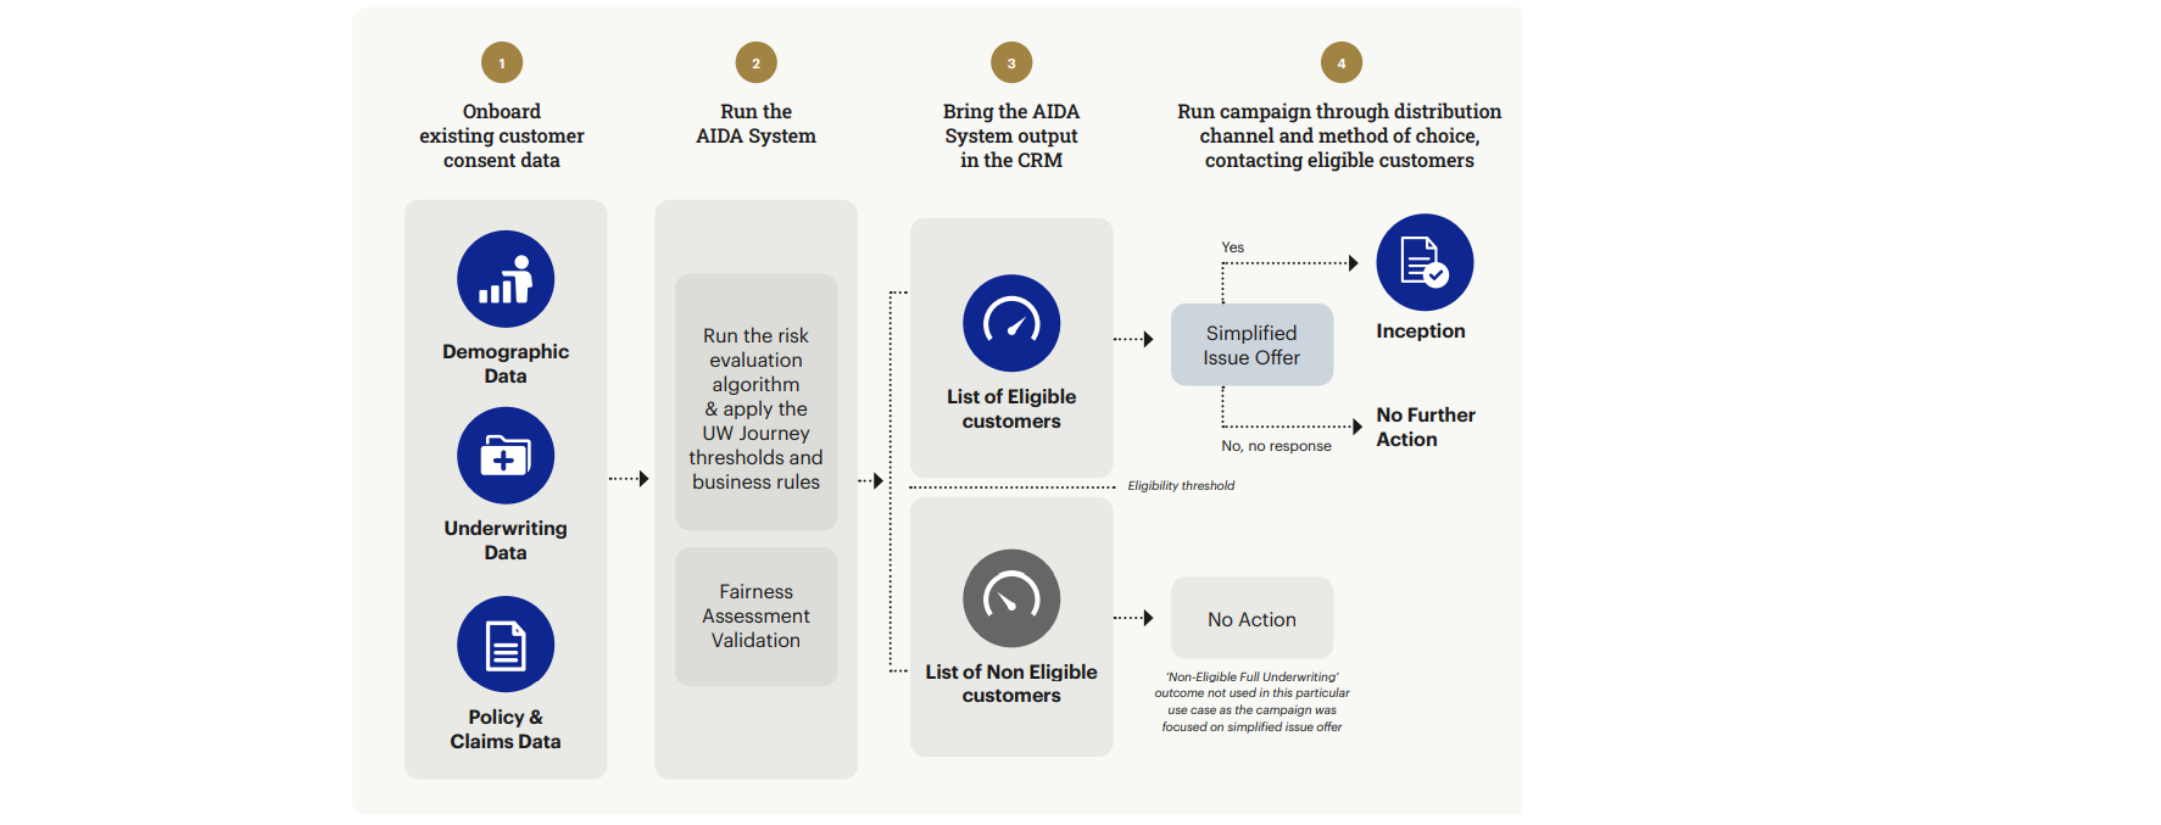

*Image obtained from Veritas Document 3C - FEAT - Transparency Principles*

- We will be using a dummy underwriting dataset from Veritas sample data for a classification problem (classify whether to underwrite customer or not)

In [ ]:
url = 'https://github.com/mas-veritas2/veritastool/blob/main/veritastool/examples/data/underwriting_dict.pickle?raw=true'
response = requests.get(url)

if response.status_code == 200:
    data = pickle.loads(response.content)
    X_train = pd.DataFrame(data['X_train'])
    X_test = pd.DataFrame(data['X_test'])
    y_train = pd.DataFrame(data['y_train']).squeeze()  # ✅ Corrected
    y_test = pd.DataFrame(data['y_test']).squeeze()
    print("✅ Data loaded successfully.")
else:
    print("❌ Failed to download the file. Status code:", response.status_code)


✅ Data loaded successfully.


In [ ]:
X_train.head()

BMI   age  annual_premium  new_pol_last_3_years  num_life_policies  \
0    0  42.0      460.791400                   0.0                1.0   
1    0  35.0      935.561460                   0.0                1.0   
2    1  44.0      100.901405                   0.0                0.0   
3    0  45.0     1243.651400                   0.0                1.0   
4    0  35.0      103.511414                   1.0                1.0   

   num_pa_policies  num_sp_policies  number_exclusions  payout_amount  \
0              0.0              0.0                0.0    5412.073700   
1              0.0              0.0                1.0    8494.875000   
2              1.0              2.0                0.0   14150.545000   
3              1.0              0.0                1.0    5001.134300   
4              0.0              0.0                0.0      28.614258   

   policy_duration  purchase_recency     tenure  gender  \
0        75.933840         61.247840   5.135544       1   
1        71.933840         71.247840   5.990438       0   
2       182.933840         34.914505  15.725551       1   
3        68.933840         61.581173   5.673532       0   
4        61.933838         38.247840   3.362101       1   

   latest_purchase_distribution_channel  latest_purchase_product_category  \
0                                     0                                 0   
1                                     0                                 0   
2                                     1                                 1   
3                                     0                                 0   
4                                     0                                 0   

   marital_status  nationality  postcode  race  smoking  
0               1            1         6     1        0  
1               1            1        14     1        0  
2               4            1        12     1        0  
3               3            1         3     1        0  
4               3            1         6     1        0

In [ ]:
y_test.head()

0    1.0
1    1.0
2    1.0
3    0.0
4    1.0
Name: 0, dtype: float64

___
### Task 1 - Setup basic RandomForest or XGBoost classifier
- Run the training and inference process, and then generate performance metrics (including AUC plot)
- Remember to generate the `y_pred` class predictions and `y_prob` probability values

### Task 2 - Define privileged/unprivileged groups
- The two protected variables are `gender` and `race`
- Create two variables based on the following criteria:
  - Privileged group (`p_grp`) is gender: 1 and race: 1
  - Underprivileged group (`up_grp`) is gender: 0 and race: [2,3]

In [ ]:
# Starter code
# p_grp = {'gender': [1], 'race': ....}

### Task 3 - Setup Model Container
- To include all the relevant parameters, including the `p_grp` and `up_grp` variables
- Hint: Refer to credit scoring example above

In [ ]:
# Starter code
# Example: container = ModelContainer(y_true, p_grp, ..... )

___
### Task 4 - Setup Predictive Underwriting Use Case Object
- For this example, we shall use the pre-defined `PredictiveUnderwriting` class in Veritas, which is designed for predictive underwriting applications
- Use the same fairness metrics as we did in the credit scoring example above

In [ ]:
# Starter code
# pred_underwriting = PredictiveUnderwriting(model_params = [container], fair_threshold = 80, ...)


___
### Task 5 - Run Fairness Diagnosis
- Use `evaluate()` to run the fairness evaluation and diagnosis

In [ ]:
# Run evaluate() here


Good job on completing this exercise!